In [1]:
import numpy as np
import pandas as pd
import psycopg2 as psy
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sb
import pickle as pic

%matplotlib inline

In [10]:
# Connect to the Lyrics Database
conn = psy.connect("dbname=test")
cur = conn.cursor()

In [12]:
# Put Data in Pandas DataFrame
songs = pd.read_sql_query("SELECT * FROM songs;", conn)
refs = pd.read_sql_query("SELECT * FROM referents;", conn)
anns = pd.read_sql_query("SELECT * FROM annotations;", conn)
all_data = pic.load(open("../Data/all_data.p"))

In [13]:
# Songs DataFrame Info
print songs.shape
print songs.info()
songs.head()

(12511, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12511 entries, 0 to 12510
Data columns (total 8 columns):
song_id                   12511 non-null int64
hot                       12511 non-null bool
unreviewed_annotations    12511 non-null int64
title                     12511 non-null object
full_title                12511 non-null object
artist                    12511 non-null object
artist_id                 12511 non-null int64
annotation_count          12511 non-null int64
dtypes: bool(1), int64(4), object(3)
memory usage: 696.5+ KB
None


,song_id,hot,unreviewed_annotations,title,full_title,artist,artist_id,annotation_count
0,2890384,False,0,0-100,0-100 by John Nonny,John Nonny,1020738,0
1,156640,False,0,0 to 100 / The Catch Up,0 to 100 / The Catch Up by Drake,Drake,130,41
2,2136824,False,0,100,100 by The Game (Ft. Drake),The Game,42,43
3,2688225,False,0,100it Racks,"100it Racks by DJ Esco (Ft. 2 Chainz, Drake & ...",DJ Esco,49470,50
4,703738,False,2,10 Bands,10 Bands by Drake,Drake,130,30


In [16]:
# Referent DataFrame Info
print refs.shape
print refs.info()
refs.head()

(163483, 6)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163483 entries, 0 to 163482
Data columns (total 6 columns):
id                163483 non-null int64
song_id           163483 non-null int64
classification    163483 non-null object
fragment          163461 non-null object
is_description    163483 non-null bool
annotator_id      163483 non-null int64
dtypes: bool(1), int64(3), object(2)
memory usage: 6.4+ MB
None


,id,song_id,classification,fragment,is_description,annotator_id
0,4961787,156640,accepted,[Part I: 0 to 100],False,605899
1,3274596,156640,accepted,"[Produced by Boi-1da, Frank Dukes, Noah ""40"" S...",False,104344
2,3272685,156640,accepted,"Maybe I'm searchin' for the problems, askin' w...",False,58812
3,3272333,156640,accepted,"The other night, Lavish Lee told me that I'm a...",False,658401
4,3272181,156640,accepted,[Bridge]\n Whole squad on that real shit\n Who...,False,18490


In [17]:
# Annotation DataFrame Info
print anns.shape
print anns.info()
anns.head()

(163401, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163401 entries, 0 to 163400
Data columns (total 12 columns):
id               163401 non-null int64
song_id          163401 non-null int64
ref_id           163401 non-null int64
ann_text         163401 non-null object
verified         163401 non-null bool
cosigned_by      163401 non-null object
has_voters       163401 non-null bool
state            163401 non-null object
community        163401 non-null bool
pinned           163401 non-null bool
comment_count    163401 non-null int64
votes_total      163401 non-null int64
dtypes: bool(4), int64(5), object(3)
memory usage: 10.6+ MB
None


,id,song_id,ref_id,ann_text,verified,cosigned_by,has_voters,state,community,pinned,comment_count,votes_total
0,4961787,156640,4961787,This song was allegedly supposed to be Diddy’s...,False,{},True,accepted,True,False,0,11
1,3274596,156640,3274596,https://twitter.com/Boi1da/status/473262859418...,False,{},True,accepted,True,False,0,56
2,3272685,156640,3272685,"Like he says in “Think Good,” Drake is constan...",False,{},True,accepted,True,False,0,19
3,3272333,156640,3272333,Lavish Lee is the best friend of Melissa Shay ...,False,{},True,accepted,True,False,0,37
4,3272181,156640,3272181,Drake’s only squads are OVO (and TOPSZN lowkey...,False,{},True,accepted,True,False,0,44


In [18]:
# Drop Empty Referents
refs.dropna(axis=0, how='any', inplace=True)

In [19]:
refs['fragment'][19]

'But when they need a favor, who do they call?'

In [20]:
# Change UTF-8 to ASCII
# Define Genius Decoder Function
def genius_decoder(x):
    if x:
        return x.decode('utf8').encode('ascii', 'ignore')
    else:
        return x

# Decode Referents and Annotations    
refs['fragment'] = refs['fragment'].apply(genius_decoder)
anns['ann_text'] = anns['ann_text'].apply(genius_decoder)

accepted         79325
unreviewed       18229
verified          1376
cosigned            48
being_created       14
Name: classification, dtype: int64


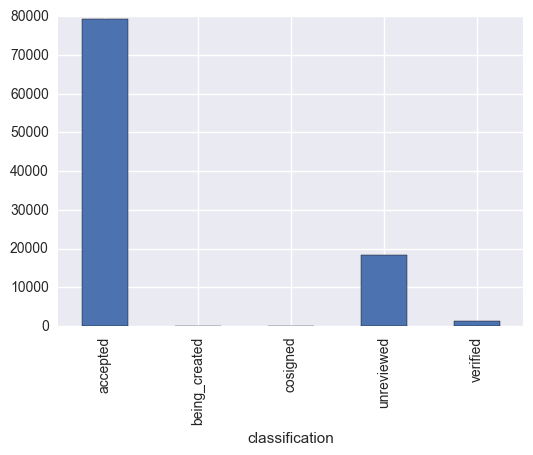

In [14]:
# Referent Classification Counts
print refs.classification.value_counts()
refs.groupby('classification').size().plot(kind='bar')

count    7048.000000
mean       20.893303
std        19.187992
min         1.000000
25%         6.000000
50%        16.000000
75%        31.250000
max       247.000000
dtype: float64


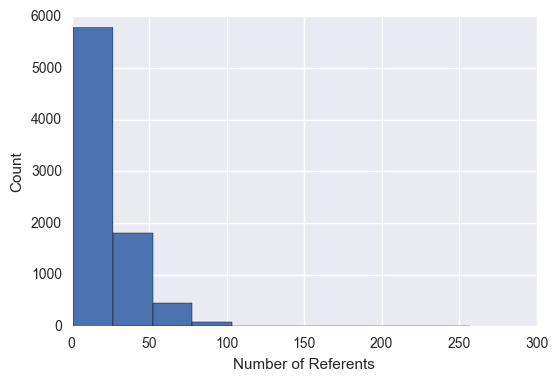

In [21]:
# Number of Referents per song
print all_data.groupby('song_id').size().describe()
refs.groupby('song_id').size().hist()
plt.xlabel('Number of Referents')
plt.ylabel('Count')

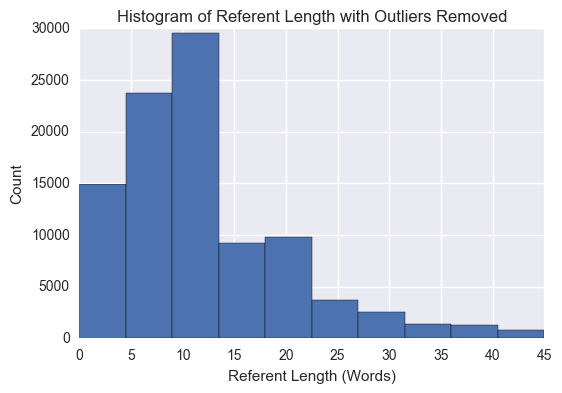

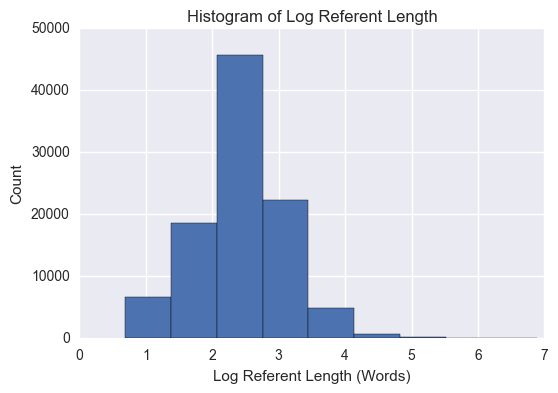

In [16]:
# Length of Referents
# Split referent fragments in order to count words
ref_length = refs['fragment'].apply(lambda x: len(x.split()))`

# Referent Length with Outliers Removed 
ref_length[ref_length < 46].hist()
plt.title('Histogram of Referent Length with Outliers Removed')
plt.xlabel('Referent Length (Words)')
plt.ylabel('Count')
plt.show()

# Log Referent Length with Outliers Included
np.log1p(ref_length).hist()
plt.title('Histogram of Log Referent Length')
plt.xlabel('Log Referent Length (Words)')
plt.ylabel('Count')
plt.show()

False    97560
True      1371
Name: verified, dtype: int64


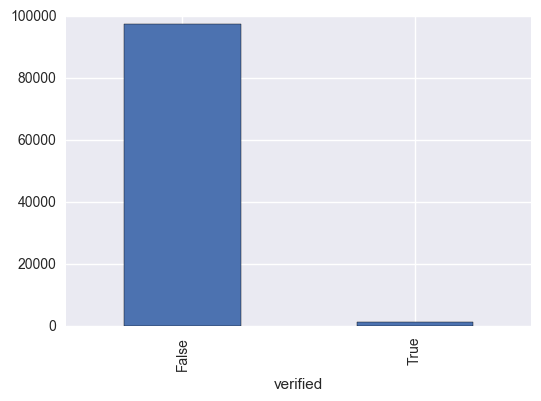

In [19]:
# Verified vs Unverified Annotations
print anns['verified'].value_counts()
anns.groupby('verified').size().plot(kind='bar')

False    97810
True      1121
Name: pinned, dtype: int64


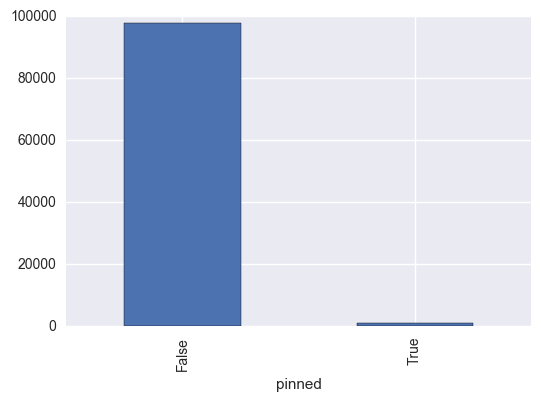

In [20]:
# Pinned vs Unpinned Annotations
print anns['pinned'].value_counts()
anns.groupby('pinned').size().plot(kind='bar')

accepted         79331
pending          18233
verified          1353
being_created       14
Name: state, dtype: int64


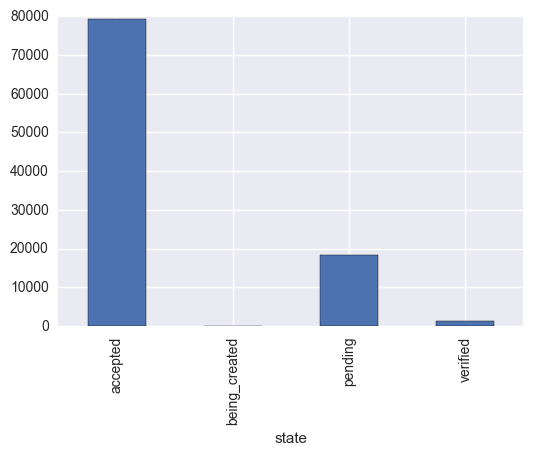

In [21]:
# Annotation State
print anns['state'].value_counts()
anns.groupby('state').size().plot(kind='bar')

0      81390
1      11790
2       3410
3       1197
4        510
5        243
6        116
7         59
8         57
9         20
11        18
10        16
12        14
16        11
14         7
13         6
15         5
32         4
25         4
22         3
17         3
18         3
19         3
20         3
81         2
21         2
34         2
24         2
26         2
27         2
29         2
56         2
36         2
37         2
23         2
52         1
51         1
67         1
57         1
54         1
69         1
64         1
50         1
42         1
47         1
44         1
106        1
232        1
40         1
33         1
28         1
59         1
Name: comment_count, dtype: int64


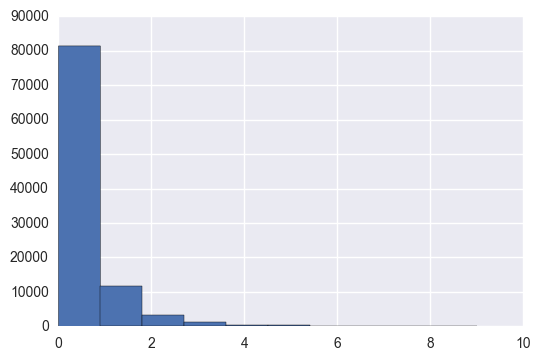

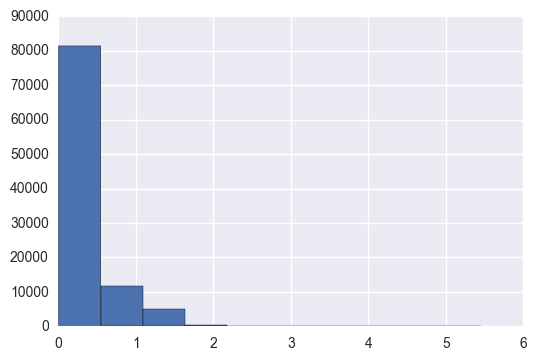

In [22]:
# Annotation Comment Count
print anns['comment_count'].value_counts()

# Annotations < 10 Comments Histogram
anns['comment_count'][anns['comment_count'] < 10].hist()
plt.show()

# Annotations < 10 Comments Histogram
np.log1p(anns['comment_count']).hist()
plt.show()

count    98931.000000
mean         6.502623
std         22.178921
min       -652.000000
25%          0.000000
50%          1.000000
75%          5.000000
max       1614.000000
Name: votes_total, dtype: float64


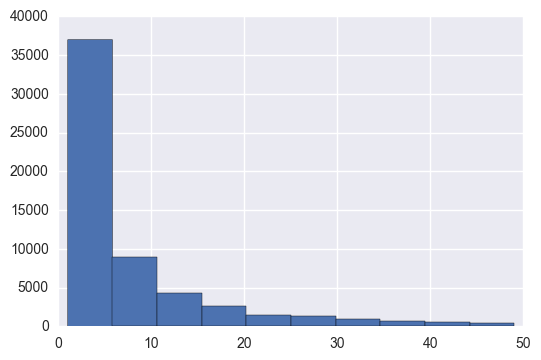

In [23]:
# Annotation Vote Totals
votes = anns['votes_total']
print anns['votes_total'].describe()

# Annotation Vote Total Histogram
votes[(votes > 0) & (votes < 50)].hist()
plt.show()

## Artists EDA

                  artist  num_of_refs
0              Lil Wayne        17850
1                 Eminem        13190
2                  Jay Z         9876
3             Kanye West         8276
4                   2Pac         7638
5                  Drake         7463
6                 Future         4600
7           Wu-Tang Clan         4344
8                50 Cent         4301
9   The Notorious B.I.G.         3357
10              Ludacris         2973
11            Snoop Dogg         2853
12               OutKast         2803
13          Beastie Boys         2201
14                   DMX         1899


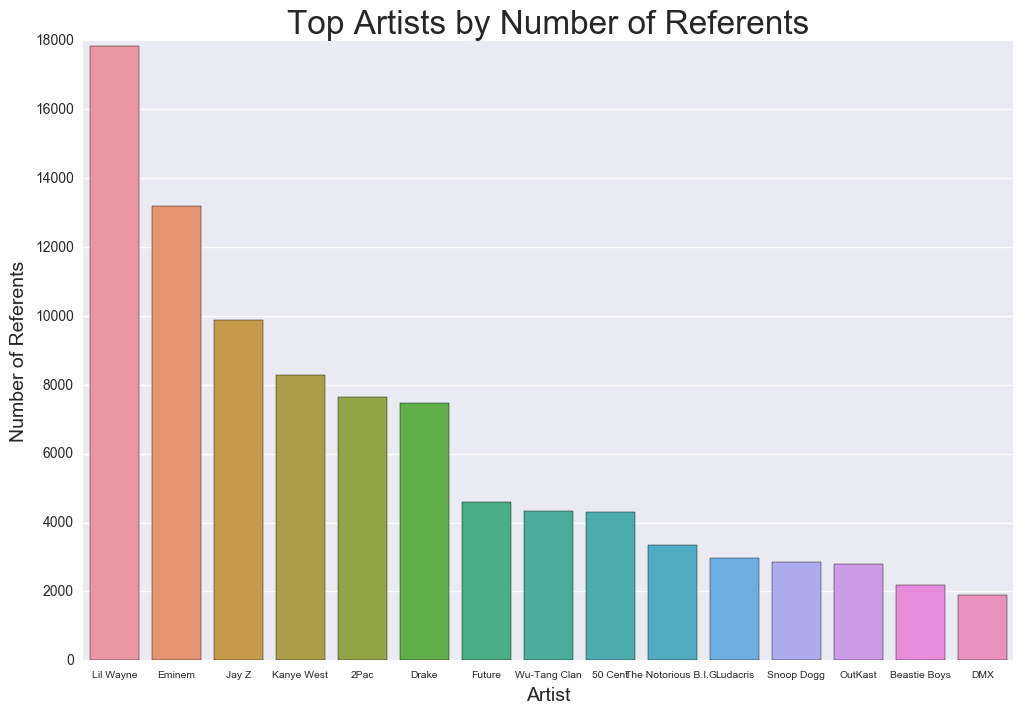

In [22]:
top_10_artists = all_data.groupby('artist').size().sort_values(ascending=False)[:15].reset_index()
top_10_artists.rename(columns={0: 'num_of_refs'}, inplace=True)
print top_10_artists
plt.figure(figsize=(12,8))
sb.barplot(x='artist', y="num_of_refs", data=top_10_artists)
plt.xlabel('Artist', fontsize=14)
plt.xticks(fontsize=7.5)
plt.ylabel('Number of Referents', fontsize=14)
plt.title('Top Artists by Number of Referents', fontsize=24)

                    artist  num_of_refs
0          Berner & B-Real           43
1        Fonzworth Bentley           43
2                DJ Scream           43
3                  Bobby V           43
4   Nice Peter & EpicLLOYD           44
5                Vic Mensa           44
6                 N.E.R.D.           44
7        The Teriyaki Boyz           44
8               Slick Rick           45
9            The Alchemist           45
10        The Lady of Rage           45
11          Glasses Malone           45
12              DJ Chop Up           45
13                Lil Durk           46
14          Little Brother           46


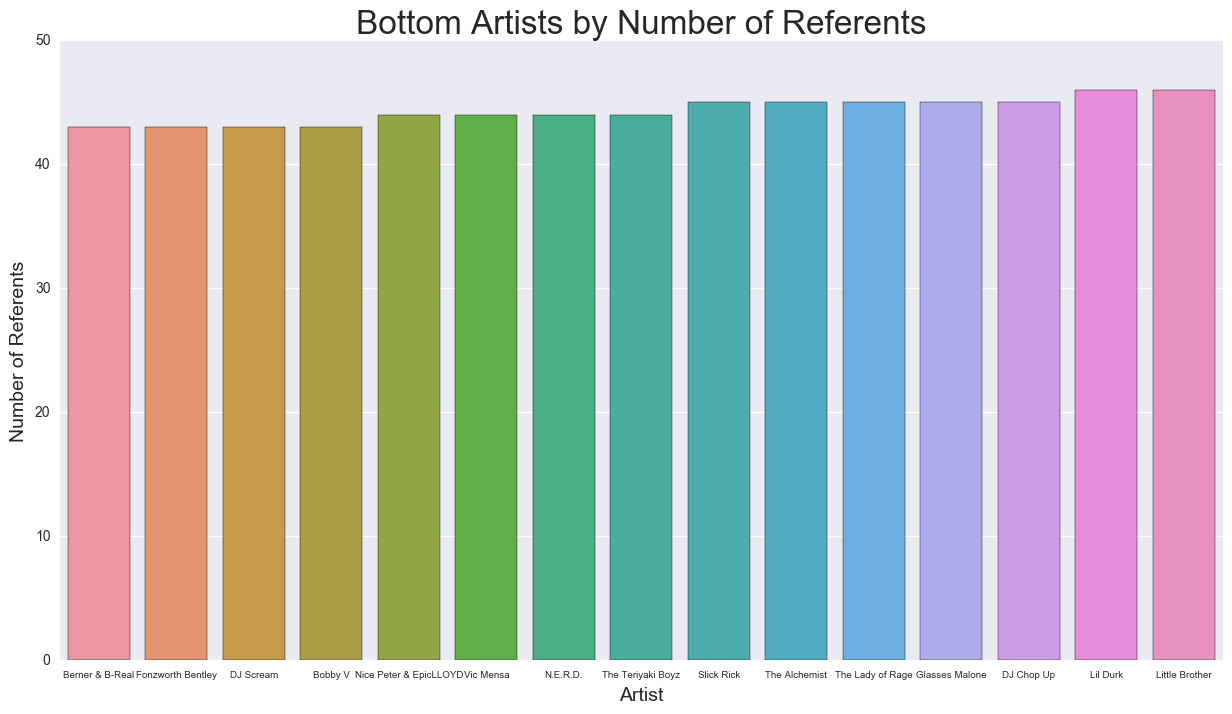

In [27]:
bottom_15_artists = all_data.groupby('artist').size().sort_values(ascending=True)[:15].reset_index()
bottom_15_artists.rename(columns={0: 'num_of_refs'}, inplace=True)
print bottom_15_artists
plt.figure(figsize=(15,8))
sb.barplot(x='artist', y="num_of_refs", data=bottom_15_artists)
plt.xlabel('Artist', fontsize=14)
plt.xticks(fontsize=7,)
plt.ylabel('Number of Referents', fontsize=14)
plt.title('Bottom Artists by Number of Referents', fontsize=24)

                  artist  num_of_refs
0              Lil Wayne         1162
1                 Eminem          737
2             Snoop Dogg          596
3             Kanye West          589
4                   2Pac          577
5                  Jay Z          548
6                  Drake          504
7                50 Cent          490
8                 Future          375
9                    DMX          326
10          Beastie Boys          318
11              Ludacris          312
12  Bone Thugs-n-Harmony          277
13                 Nelly          240
14               OutKast          219


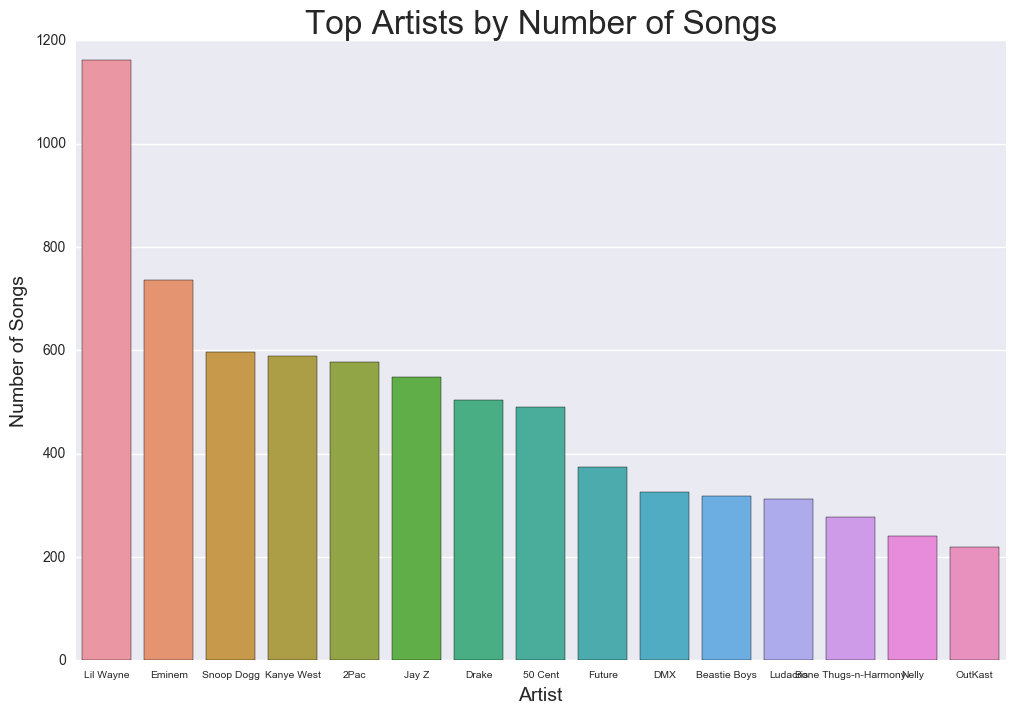

In [36]:
top_15_artists_song = songs.groupby('artist').size().sort_values(ascending=False)[:15].reset_index()
top_15_artists_song.rename(columns={0: 'num_of_refs'}, inplace=True)
print top_15_artists_song
plt.figure(figsize=(12,8))
sb.barplot(x='artist', y="num_of_refs", data=top_15_artists_song)
plt.xlabel('Artist', fontsize=14)
plt.xticks(fontsize=7.5)
plt.ylabel('Number of Songs', fontsize=14)
plt.title('Top Artists by Number of Songs', fontsize=24)

In [30]:
all_data['ann_length'] = all_data['ann_text'].apply(lambda x: len(x.split()))
all_data['ref_length'] = all_data['fragment'].apply(lambda x: len(x.split()))

## Length EDA

count    147256.000000
mean         36.002411
std          32.857167
min           1.000000
25%          15.000000
50%          27.000000
75%          46.000000
max        1095.000000
Name: ann_length, dtype: float64


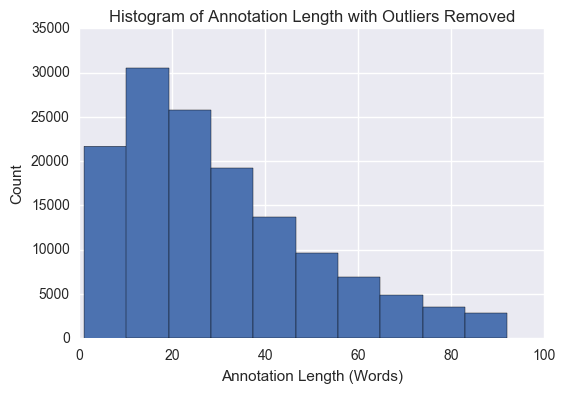

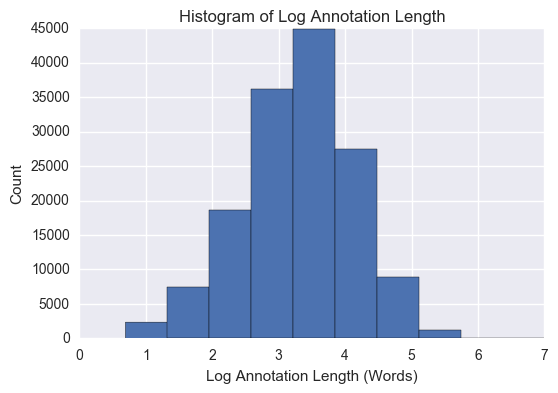

In [44]:
# Length of Annotations
# Split annotation text in order to count words
ann_length = all_data['ann_length']
print ann_length.describe()
ann_length_q3 = np.percentile(ann_length, 75)
ann_length_q1 = np.percentile(ann_length, 25)
ann_length_iqr = ann_length_q3 - ann_length_q1


# Annotation Length with Outliers Removed 
ann_length[ann_length < ann_length_q3 + 1.5 * ann_length_iqr].hist()
plt.title('Histogram of Annotation Length with Outliers Removed')
plt.xlabel('Annotation Length (Words)')
plt.ylabel('Count')
plt.show()

# Log Annotation Length with Outliers Included
np.log1p(ann_length).hist()
plt.title('Histogram of Log Annotation Length')
plt.xlabel('Log Annotation Length (Words)')
plt.ylabel('Count')
plt.show()

count    147256.000000
mean         12.817671
std          14.181841
min           1.000000
25%           7.000000
50%          10.000000
75%          15.000000
max         985.000000
Name: ref_length, dtype: float64


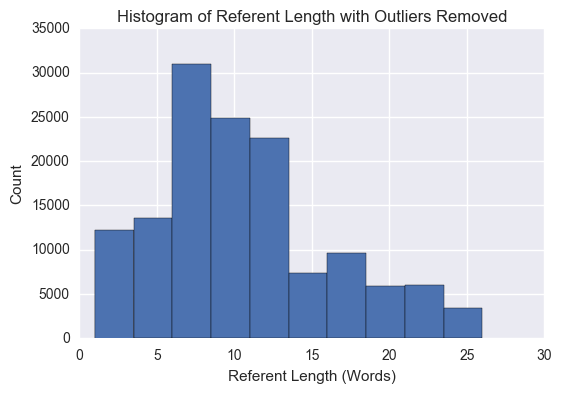

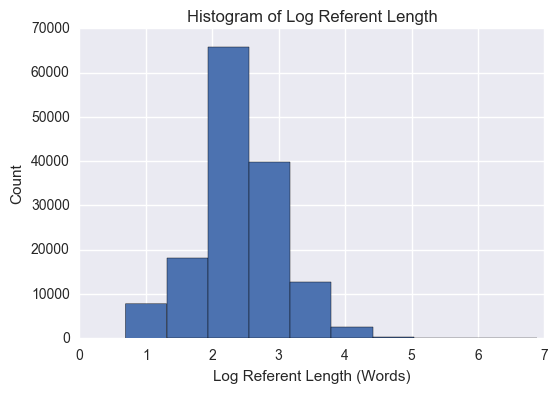

In [45]:
# Length of Referents
ref_length = all_data['ref_length']
print ref_length.describe()
ref_length_q3 = np.percentile(ref_length, 75)
ref_length_q1 = np.percentile(ref_length, 25)
ref_length_iqr = ref_length_q3 - ref_length_q1


# Referent Length with Outliers Removed 
ref_length[ref_length < ref_length_q3 + 1.5 * ref_length_iqr].hist()
plt.title('Histogram of Referent Length with Outliers Removed')
plt.xlabel('Referent Length (Words)')
plt.ylabel('Count')
plt.show()

# Log Referent Length with Outliers Included
np.log1p(ref_length).hist()
plt.title('Histogram of Log Referent Length')
plt.xlabel('Log Referent Length (Words)')
plt.ylabel('Count')
plt.show()

/Users/nehemiahloury/anaconda/envs/dsi/lib/python2.7/site-packages/pandas/core/frame.py:2754: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


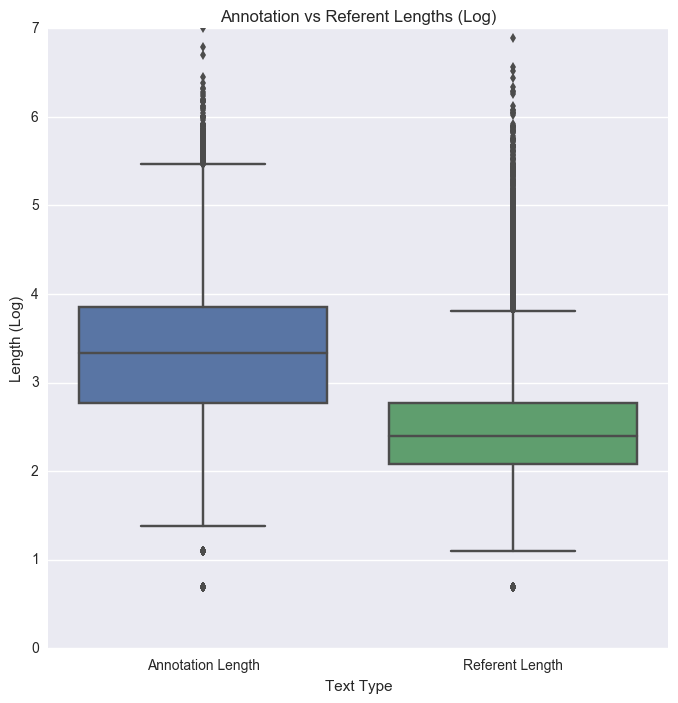

In [33]:
# Log of Annotation Length vs Referent Length

# Prepare Data
text_data = all_data[['ann_length', 'ref_length']]
text_data.rename(columns={'ann_length': 'Annotation Length', 'ref_length': 'Referent Length'}, inplace=True)
text_data_long = pd.melt(text_data)
text_data_long['Length (Log)'] = text_data_long['value'].apply(lambda x: np.log1p(x))

# Plot
plt.figure(figsize=(8,8))
sb.boxplot(x = 'variable', y = 'Length (Log)', data=text_data_long)
plt.xlabel('Text Type')
plt.title('Annotation vs Referent Lengths (Log)')

count    7048.000000
mean      267.803490
std       245.045059
min         1.000000
25%        76.750000
50%       216.000000
75%       408.000000
max      5644.000000
Name: ref_length, dtype: float64


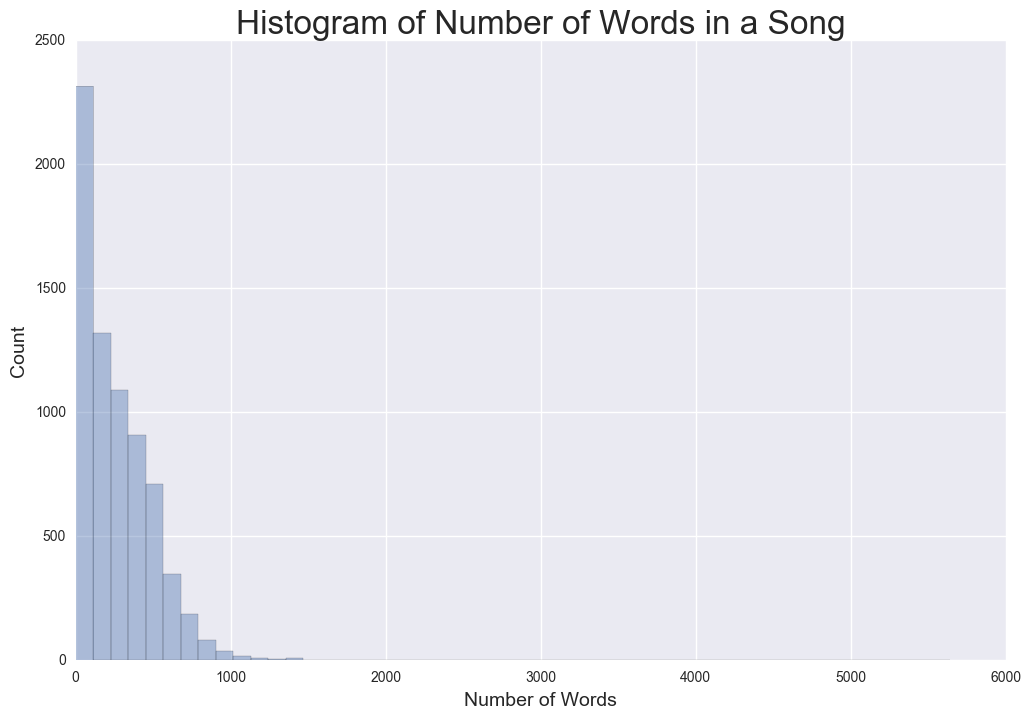

In [53]:
song_length = all_data.groupby('song_id')['ref_length'].sum()
print song_length.describe()
plt.figure(figsize=(12,8))
sb.distplot(song_length, kde=False)
plt.xlabel('Number of Words', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Histogram of Number of Words in a Song', fontsize=24)

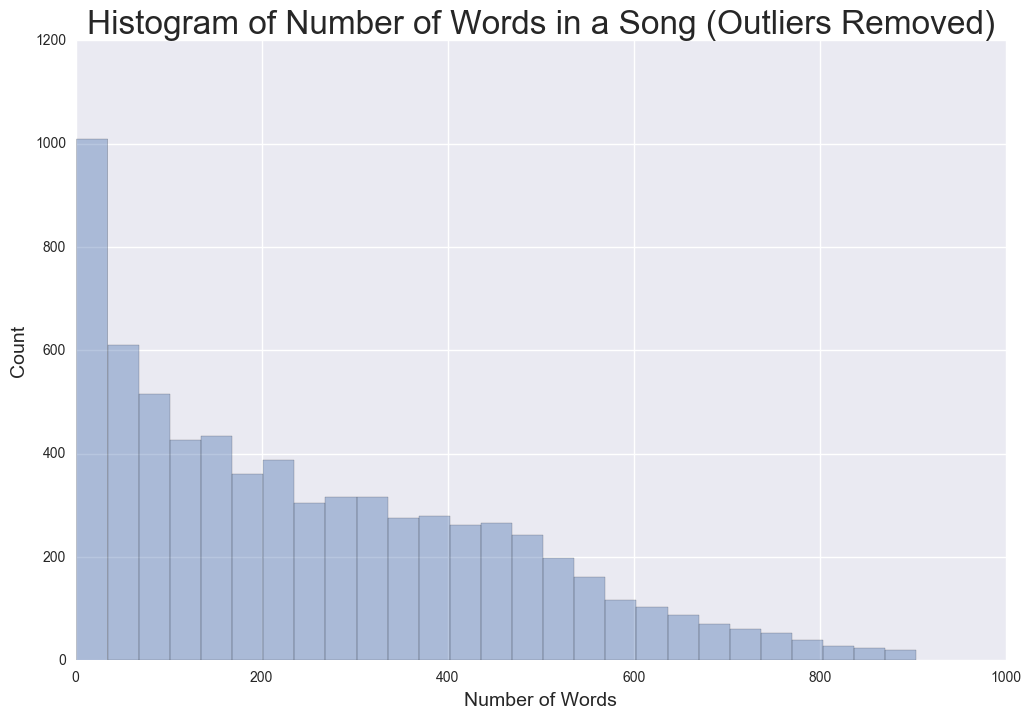

In [52]:
# Remove Outliers
song_length_q3 = np.percentile(song_length, 75)
song_length_q1 = np.percentile(song_length, 25)
song_length_iqr = song_length_q3 - song_length_q1
song_length_no_out = song_length[song_length < song_length_q3 + 1.5 * song_length_iqr]

# Plot
plt.figure(figsize=(12,8))
sb.distplot(song_length_no_out, kde=False)
plt.xlabel('Number of Words', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Histogram of Number of Words in a Song (Outliers Removed)', fontsize=24)

## LDA Clustering

## LSA

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
import nltk, string

In [26]:
# LSA for Information Retrieval
# Create Stemmer
stemmer = nltk.stem.porter.PorterStemmer()
trans_table = {ord(c): None for c in string.punctuation}
# Define Preprocessing Functions
def stem_tokens(tokens):
    return [stemmer.stem(item) for item in tokens]

def normalize(text):
    return stem_tokens(nltk.word_tokenize(text.lower().translate(trans_table)))

In [186]:
# Tfidf Vectorizer
# - Strip out "stop words"
# - Normalize by Stemming, lowering the case, and removing punctuation

vectorizer = TfidfVectorizer(tokenizer=normalize, max_df=0.5, 
                             max_features=10000, min_df=2, 
                             stop_words='english', use_idf=True)


# Vectorize the annotations
annotations = anns['ann_text'].values
ann_tfidf = vectorizer.fit_transform(annotations)


In [195]:
feat_names = vectorizer.get_feature_names()

In [198]:
# Perform Latent Semantic Analysis on annotations
svd = TruncatedSVD(100)
lsa = make_pipeline(svd, Normalizer(copy=False))
X_train_lsa = lsa.fit_transform(ann_tfidf)

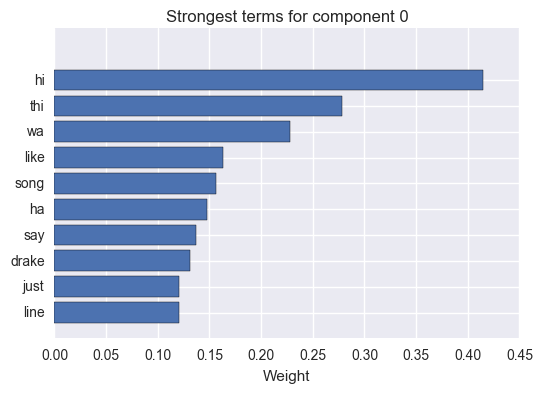

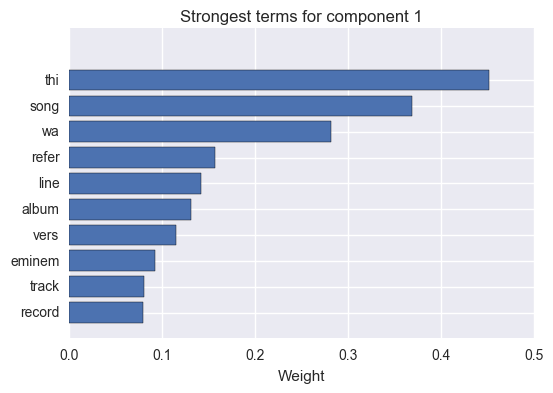

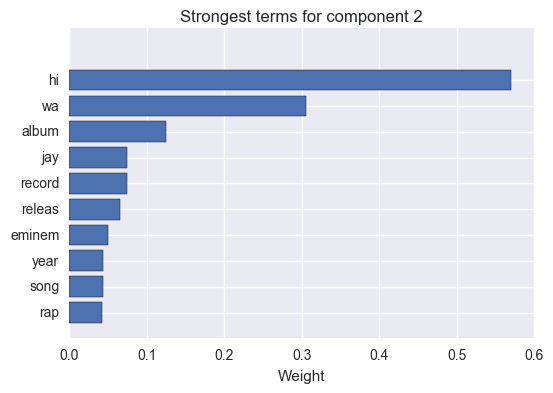

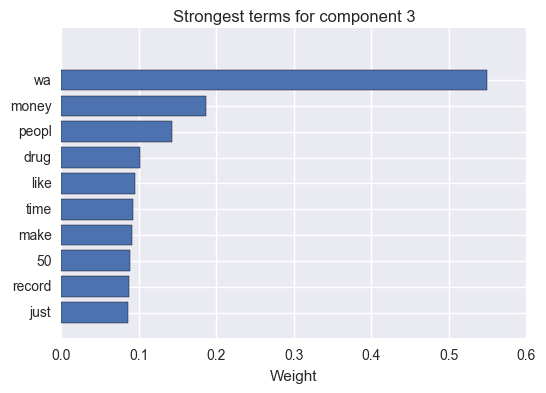

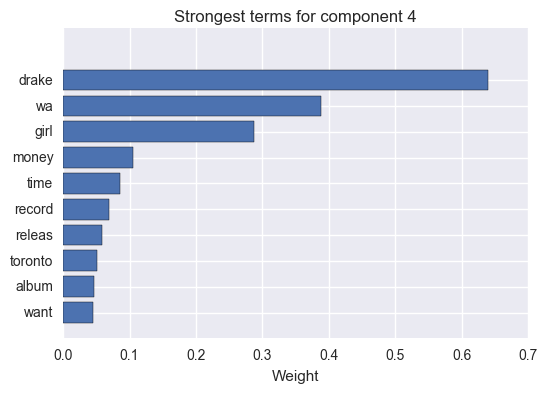

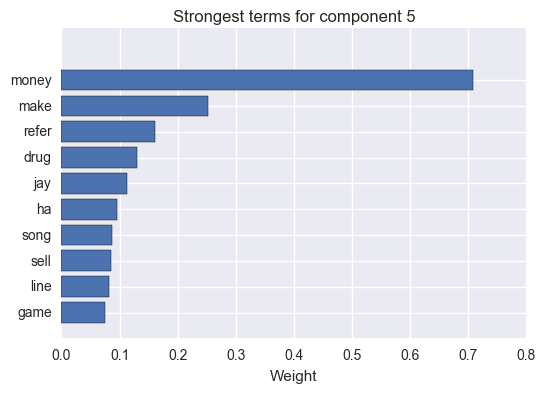

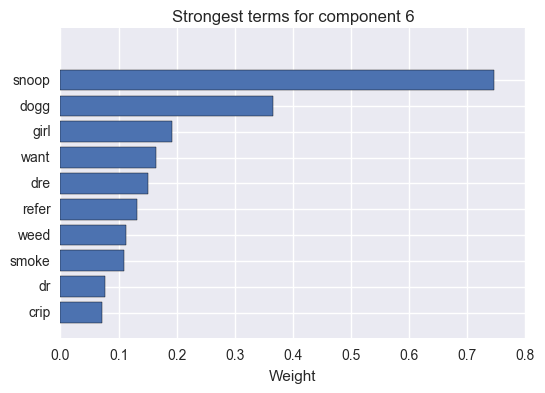

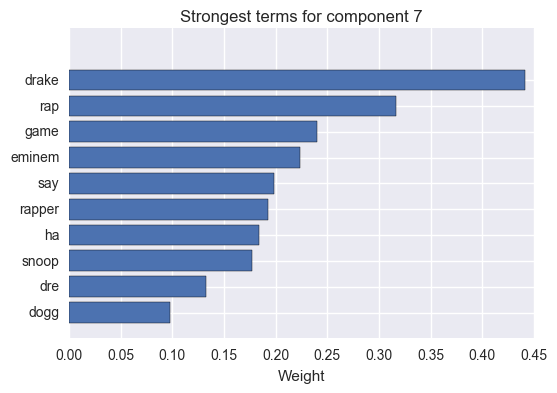

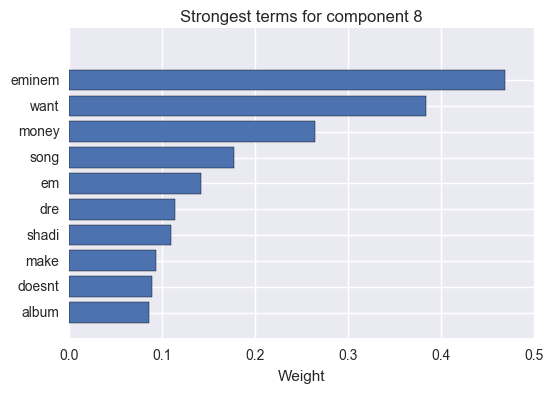

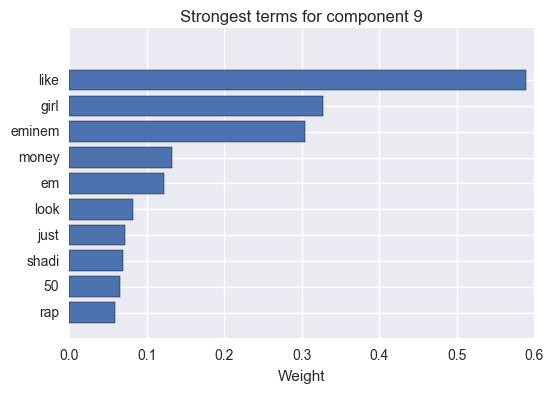

In [207]:
for compNum in range(0, 10):

    comp = svd.components_[compNum]
    
    # Sort the weights in the first component, and get the indeces
    indeces = np.argsort(comp).tolist()
    
    # Reverse the indeces, so we have the largest weights first.
    indeces.reverse()
    
    # Grab the top 10 terms which have the highest weight in this component.        
    terms = [feat_names[weightIndex] for weightIndex in indeces[0:10]]    
    weights = [comp[weightIndex] for weightIndex in indeces[0:10]]    
   
    # Display these terms and their weights as a horizontal bar graph.    
    # The horizontal bar graph displays the first item on the bottom; reverse
    # the order of the terms so the biggest one is on top.
    terms.reverse()
    weights.reverse()
    positions = range(1,11)    # the bar centers on the y axis
    
    plt.figure(compNum)
    plt.barh(positions, weights, align='center')
    plt.yticks(positions, terms)
    plt.xlabel('Weight')
    plt.title('Strongest terms for component %d' % (compNum))
    plt.grid(True)
    plt.show()

In [33]:
# Pickle our databases
pic.dump(songs, open("./Data/songs.p", "wb"))
pic.dump(refs, open("./Data/referents.p", "wb"))
pic.dump(anns, open("./Data/annotations.p", "wb"))